In [1]:
import torch
from torch.utils.data import Dataset,random_split, DataLoader, Subset
import torch.nn as nn
from zipfile import ZipFile
import pandas
from PIL import Image
from io import BytesIO
from time import time

import numpy as np

import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
from torchsummary import summary


In [2]:
# Set device type
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Current Device: {device}')
device_count = torch.cuda.device_count() # Number of GPUs available
print(f'Number of devices: {device_count}')

Current Device: cuda
Number of devices: 1


In [3]:
zip_location = '../Data/face_images.zip'


In [4]:
with ZipFile(zip_location,'r') as zf:
    files = ['face_image_attr.csv', 
             'face_image_bbox.csv',
             'face_image_eval_partition.csv']
    with zf.open(files[0]) as f:
        attr = pandas.read_csv(f)
    with zf.open(files[1]) as f:
        bbox = pandas.read_csv(f)
    with zf.open(files[2]) as f:
        eval_part = pandas.read_csv(f)
    

# 202599

In [38]:
attr.Arched_Eyebrows = [0  if x == -1 else 1 for x in attr.Arched_Eyebrows]
attr

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,0,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,0,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,0,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202594,202595.jpg,-1,0,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1
202595,202596.jpg,-1,0,-1,-1,-1,1,1,-1,-1,...,-1,1,1,-1,-1,-1,-1,-1,-1,1
202596,202597.jpg,-1,0,-1,-1,-1,-1,-1,-1,1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
202597,202598.jpg,-1,1,1,-1,-1,-1,1,-1,1,...,-1,1,-1,1,1,-1,1,-1,-1,1


In [39]:
img_files = attr.image_id
img_files = "face_images/img_align_celeba/" + img_files

In [40]:
img_files[42].removeprefix("face_images/img_align_celeba/")

'000043.jpg'

In [41]:
with ZipFile(zip_location,'r') as zf:
    with zf.open(img_files[0]) as file:
        img_data = file.read()

In [42]:
img = Image.open(BytesIO(img_data))

In [43]:
"""
start_time = time()
# using with as syntax to open each file individually

for f in img_files[:20]:
    with ZipFile(zip_location,'r') as zf:
        with zf.open(f) as file:
            img_data = file.read()

end_time = time()

print(end_time-start_time)
"""

"\nstart_time = time()\n# using with as syntax to open each file individually\n\nfor f in img_files[:20]:\n    with ZipFile(zip_location,'r') as zf:\n        with zf.open(f) as file:\n            img_data = file.read()\n\nend_time = time()\n\nprint(end_time-start_time)\n"

In [44]:
"""
start_time = time()
# using with as syntax to open filez under a single zip file

with ZipFile(zip_location,'r') as zf:
    for f in img_files[:20]:
        with zf.open(f) as file:
            img_data = file.read()

end_time = time()

print(end_time-start_time)
"""

"\nstart_time = time()\n# using with as syntax to open filez under a single zip file\n\nwith ZipFile(zip_location,'r') as zf:\n    for f in img_files[:20]:\n        with zf.open(f) as file:\n            img_data = file.read()\n\nend_time = time()\n\nprint(end_time-start_time)\n"

In [45]:
"""
start_time = time()
# using with as syntax to open files under a single zip file

zf = ZipFile(zip_location,'r')
for f in img_files[:20]:
    with zf.open(f) as file:
        img_data = file.read()

end_time = time()

print(end_time-start_time)
"""

"\nstart_time = time()\n# using with as syntax to open files under a single zip file\n\nzf = ZipFile(zip_location,'r')\nfor f in img_files[:20]:\n    with zf.open(f) as file:\n        img_data = file.read()\n\nend_time = time()\n\nprint(end_time-start_time)\n"

In [46]:
class ZipImageDataset(Dataset):
    def __init__(self, zip_file_path, file_list, transform=None):
        self.zip_file_path = zip_file_path
        self.file_list = file_list
        self.transform = transform
        self.zip_file = ZipFile(self.zip_file_path, 'r')  # Open zip file once

    def __getitem__(self, idx):
        image_file = self.file_list[idx]
        label = attr.Arched_Eyebrows[idx]

        with self.zip_file.open(image_file) as file:
            image = Image.open(BytesIO(file.read()))
            image = image.convert('RGB')
            
            if self.transform:
                image = self.transform(image)
            
            
            return (image,label)
    
    def close(self):
        self.zip_file.close()

    def __del__(self):
        self.close()  # Ensure that the zip file is closed when the dataset is done
    def __len__(self):
        return len(self.file_list)


In [47]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [48]:
img_dataset = ZipImageDataset(zip_location, img_files, transform)

In [49]:
dataset_size = len(img_files)

# Split dataset into train (70%), validation (15%), and test (15%)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

# Split dataset
train_dataset, val_dataset, test_dataset = random_split(img_dataset, [train_size, val_size, test_size])

num_train_examples = 1000  # Change this number to adjust the dataset size

# Create a subset of the training data
train_subset = Subset(train_dataset, range(num_train_examples))

batch_size = 16
# Create DataLoaders for train, validation, and test sets
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [50]:
print(f'Train: {train_size}')
print(f'Validation: {val_size}')
print(f'Test: {test_size}')

Train: 141819
Validation: 30389
Test: 30391


In [51]:
def reverse_normalize(tensor, mean, std):
    # Normalize in reverse: (normalized_value * std) + mean
    mean = torch.tensor(mean).view(-1, 1, 1)
    std = torch.tensor(std).view(-1, 1, 1)
    return tensor * std + mean

In [52]:
tensor_to_image = transforms.ToPILImage()

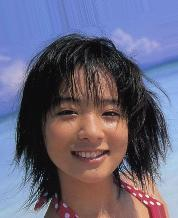

In [53]:
tensor_to_image(test_dataset[42][0])

# ResNet 18 

### ResidualBlock(in,out)
- Conv2d(in,out)
- BatchNorm2d(out,out)
- ReLU(out,out)
- Conv2d(out,out)
- BatchNorm2d(out,out)
- downsampling
- out = out + in
- ReLU(out,out)

### SequentialLayer(in,out)
- ResidualBlock(in,out)
- ResidualBlock(out,out)


### Resnet18
- Input
- Conv2d(input_channnel = 3, output_channels = 64, kernel_size = (7,7), padding = (3,3)
- BatchNorm2d(channels = 64)
- ReLU
- MaxPool2d(kernel_size=3,stride=2,padding=1)
- SequentialLayer(input_channel = 64, output_channel = 64)
- SequentialLayer(64,128)
- SequentialLayer(128,256)
- SequentialLayer(256,512)
- GlobalAvgPool2d()
- Linear(512,1000)



Link to code: https://pytorch.org/vision/2.0/_modules/torchvision/models/resnet.html#resnet18

In [54]:
model = models.resnet18(weights='IMAGENET1K_V1')

In [55]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [56]:
next(model.parameters()).is_cuda

True

In [57]:
c = 0
for input_batch,label_batch in train_loader:
    c+=1
    if c==1:
        print(input_batch.shape)
print(c)


torch.Size([16, 3, 218, 178])
63


In [58]:
for name,param in model.named_parameters():
    print(name)

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.weight
layer2.1.bn2.weight
layer2.1.bn2.bias
layer3.0.conv1.weight
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.conv2.weight
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.downsample.0.weight
layer3.0.downsample.1.weight
layer3.0.downsample.1.bias
layer3.1.conv1.weight
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.conv2.weight
layer3.1.bn2.weight
layer3.1.bn2.bias
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.we

In [59]:
model.layer1[0].conv1

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [60]:
model.fc = nn.Linear(512,1)

# Experiments
- Freezing all layers except layer 4 onwards with SGD
- Freezing all layers except layer 3 onwards with SGD
- Freezing all layers except layer 4 onwards with AdamW
- Freezing all layers except layer 3 onwards with AdamW
- Transform all images into subsets(their bounding boxes) and retry

In [30]:
for name,param in model.named_parameters():
    if "layer4" in name:
        break
    param.requires_grad = False

In [31]:
for name,param in model.named_parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
